In [1]:
import numpy as np
import pandas as pd

from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt
from numpy.typing import NDArray
from tabulate import tabulate
from xgboost import XGBClassifier

from sklearn.calibration import calibration_curve
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, make_scorer
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    learning_curve,
    LearningCurveDisplay,
    StratifiedKFold,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler

from mads_telemarketing_assignment.config import (
    DATA_FILENAME,
    HONOLULU_BLUE,
    IMPERIAL_RED,
    PROCESSED_DATA_DIR,
)
from mads_telemarketing_assignment.metrics import calculate_cost_estimates, calculate_profit_thresholds
from mads_telemarketing_assignment.visualization import plot_profit_thresholds

In [2]:
# Various variables used in the code
random_state = 42

In [3]:
# Load dataset
df = pd.read_csv(PROCESSED_DATA_DIR / DATA_FILENAME, sep=",")

In [4]:
if "duration" in df.columns:
    # Duration is not a feature we want to use for prediction
    # as it is only known after the call has been made.
    # It can lead to data leakage if used in training.
    df = df.drop(columns=["duration"])

In [5]:
if "approached" in df.columns:
    df = df.drop(columns=["approached"])

In [6]:
if "year" in df.columns:
    df = df[df["year"] != 2008]
    df = df.drop(columns=["year"])


In [7]:
# Define X and y for modeling
X = df.drop(columns=["y"], axis=1)
y = df["y"]

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (13498, 19), y shape: (13498,)


In [8]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y.squeeze())  # Ensure y is 1D

In [9]:
# Transform features to prepare for modelling
transformer = ColumnTransformer(
    [
        (
            "categorical",
            OneHotEncoder(),
            [
                "contact",
                "day_of_week",
                "default",
                "education",
                "education",
                "housing",
                "job",
                "loan",
                "marital",
                "month",
                "poutcome",
            ],
        ),
    ],
    remainder=MinMaxScaler(),
)
X = transformer.fit_transform(X)

In [10]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=random_state)

X_resampled, y_resampled = smote.fit_resample(X, y)

print(f"X_resampled shape: {X_resampled.shape}, y_resampled shape: {y_resampled.shape}")

X_resampled shape: (20394, 69), y_resampled shape: (20394,)


In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled,
    y_resampled,
    random_state=random_state,
    test_size=0.2,  # 20% of the data for testing
)

In [12]:
# # Calculate the cost estimates for train and test sets
# train_cost_estimates = calculate_cost_estimates(X_train, y_train)
# test_cost_estimates = calculate_cost_estimates(X_test, y_test)

In [13]:
# Define function to calculate maximum profit
def calculate_maximum_profit(
    y_true: NDArray[np.int32],
    y_probs: NDArray[np.float32],
) -> int:
    # Calculate various metrics based on profit thresholds
    results = calculate_profit_thresholds(y_true, y_probs)
    # Return the profit margin as the score
    return results[4]


# Define scorer for maximum profit calculation
maximum_profit_scorer = make_scorer(
    calculate_maximum_profit,
    response_method="predict_proba",
    greater_is_better=True,
)

In [14]:
# Define list of classifiers to be used in modeling process
classifiers = {
    # "AdaBoost": [
    #     AdaBoostClassifier(random_state=random_state),
    #     {
    #         # "learning_rate": [0.01],
    #     },
    # ],
    # "Gradient Boosting": [
    #     GradientBoostingClassifier(random_state=random_state),
    #     {
    #         # "n_estimators": [100, 200, 300],
    #         # "learning_rate": [0.1, 0.01, 0.001],
    #         # "max_depth": [3, 5, 7],
    #     },
    # ],
    # "K-Nearest Neighbors": [
    #     KNeighborsClassifier(n_jobs=-1),
    #     {
    #         # "n_neighbors": [3, 5, 7],
    #         # "weights": ["uniform", "distance"],
    #         # "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    #     },
    # ],
    # "Logistic Regression": [
    #     LogisticRegression(random_state=random_state, max_iter=1000),
    #     {
    #         # "penalty": ["l2", "none"],
    #         # "C": [0.1, 1.0, 10.0],
    #         # "solver": ["lbfgs", "liblinear"],
    #     },
    # ],
    "Random Forest": [
        RandomForestClassifier(random_state=random_state),
        {
            # "n_estimators": [100, 200, 300],
            # "max_depth": [10, 20, 30],
            # "min_samples_split": [2, 5, 10],
            # "min_samples_leaf": [1, 2, 4],
        },
    ],
    # "XGBoost": [
    #     XGBClassifier(random_state=random_state),
    #     {
    #         # "n_estimators": [100, 200, 300],
    #         # "learning_rate": [0.1, 0.01, 0.001],
    #         # "max_depth": [3, 5, 7],
    #     },
    # ],
}

In [15]:
is_hypertuning_enabled = False  # Set to True to enable hypertuning

if is_hypertuning_enabled:
    print("Start hypertuning:")

    # Loop through each classifier and perform grid search for hyperparameter tuning
    for name, (classifier, param_grid) in classifiers.items():
        print(f"- {name}")

        grid_search = GridSearchCV(
            cv=5,
            estimator=classifier,
            n_jobs=-1,
            param_grid=param_grid,
            scoring=maximum_profit_scorer,
        )
        grid_search.fit(X_train, y_train)
        # Overwrite the classifier with the best found parameters
        classifiers[name] = [grid_search.best_estimator_, grid_search.best_params_]

    print("✅ Hypertuning completed.")
else:
    print("⏩ Hypertuning skipped.")

⏩ Hypertuning skipped.


In [16]:
kf = KFold(n_splits=5)
y_probs = {}
y_preds = {}

print("Start modelling:")

# Loop through each classifier, fit, cross-validate and store results
for name, (classifier, _) in classifiers.items():
    print(f"- {name}")

    # Prepare an array to store predictions for all training samples
    y_prob = np.zeros(len(y_train))
    y_pred = np.zeros(len(y_train))

    for fold_train_index, fold_test_index in kf.split(X_train, y_train):
        # Split the data into training and test folds
        X_fold_train, X_fold_test = (
            X_train[fold_train_index],
            X_train[fold_test_index],
        )
        y_fold_train, y_fold_test = (
            y_train[fold_train_index],
            y_train[fold_test_index],
        )
        # Fit the pipeline on the training fold
        classifier.fit(X_fold_train, y_fold_train)
        # Make and store probabilities and predictions for the test fold
        y_prob[fold_test_index] = classifier.predict_proba(X_fold_test)[:, 1]
        y_pred[fold_test_index] = classifier.predict(X_fold_test)

    y_probs[name] = y_prob
    y_preds[name] = y_pred

print("✅ Modelling completed.")

Start modelling:
- Random Forest
✅ Modelling completed.


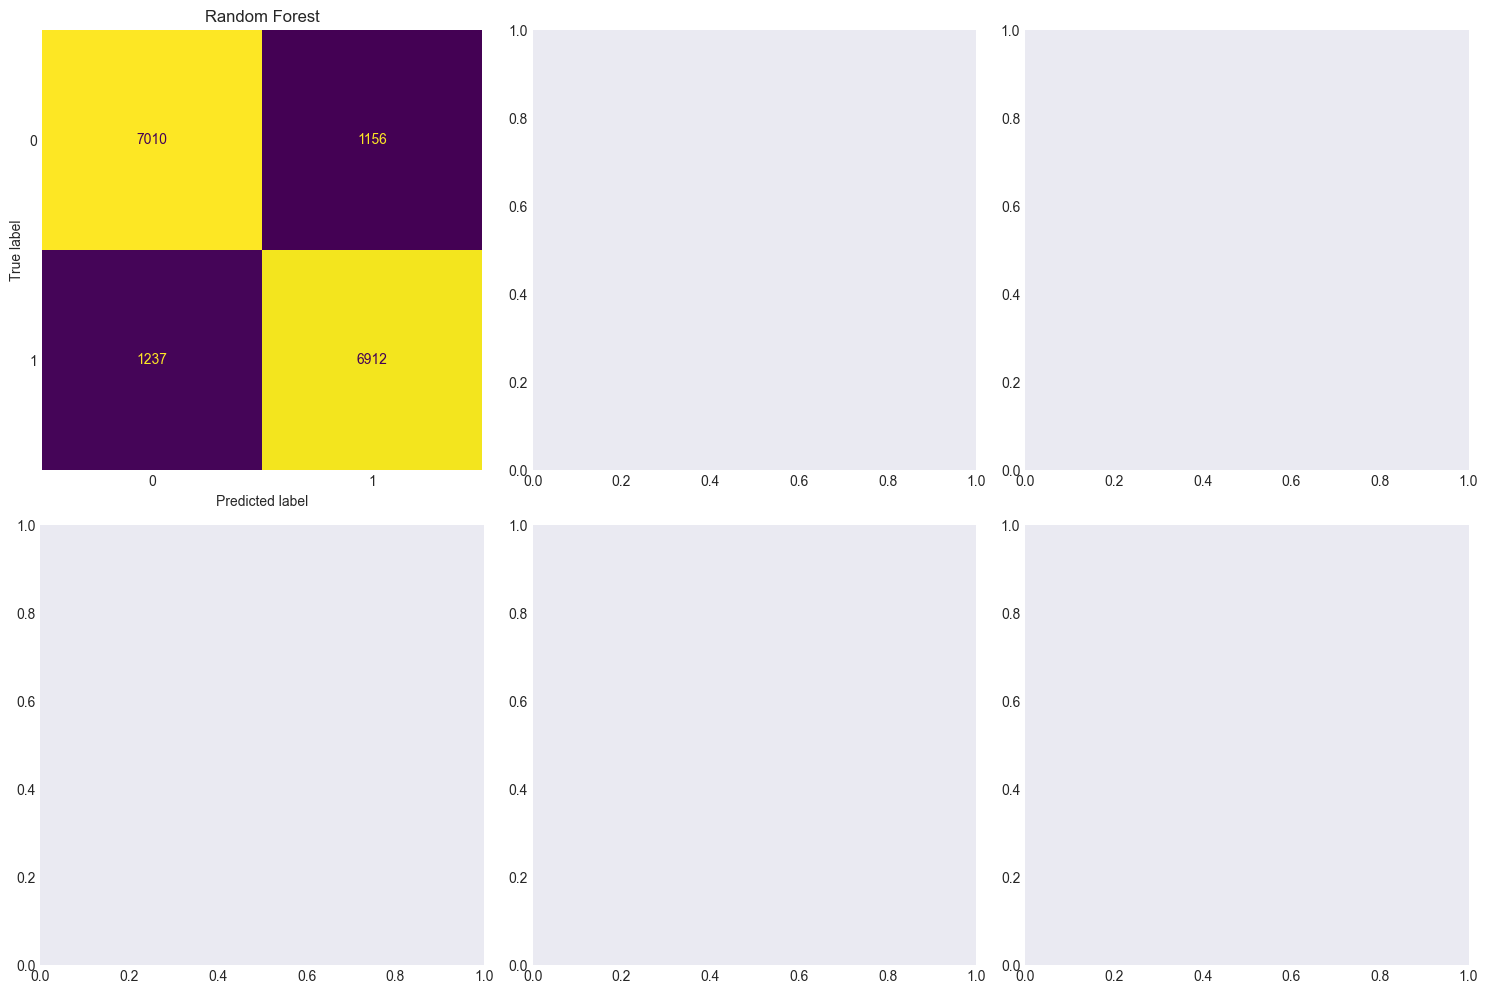

In [17]:
plt.style.use("seaborn-v0_8-dark")

_, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax, (model_name, y_pred) in zip(axes.flatten(), y_preds.items()):
    ConfusionMatrixDisplay.from_predictions(
        y_train,
        y_pred,
        ax=ax,
        colorbar=False,
    )
    ax.set_title(model_name)

plt.tight_layout()
plt.show()

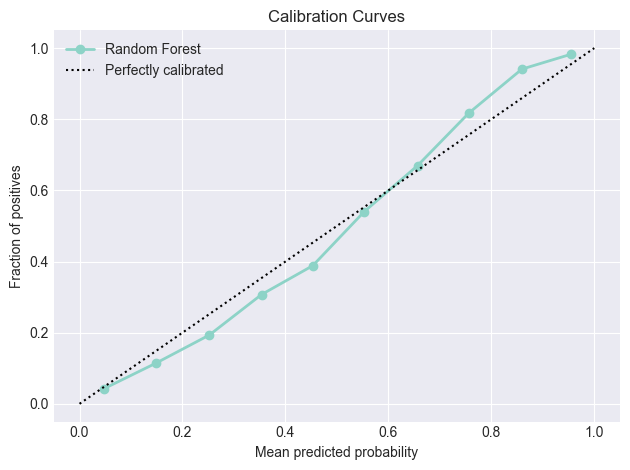

In [18]:
plt.style.use("seaborn-v0_8-darkgrid")

plt.figure()

for model_name, y_prob in y_probs.items():
    prob_true, prob_pred = calibration_curve(y_train, y_prob, n_bins=10)
    plt.plot(prob_pred, prob_true, marker="o", label=model_name, linewidth=2)

plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curves")
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
# Define dictionary to store metrics for each classifier
metrics = {}

# Calculate various metrics based on the results of the classifiers
for name, y_prob in y_probs.items():
    # Calculate profit thresholds and metrics
    metrics[name] = calculate_profit_thresholds(
        y_train,
        y_prob,
        # cost_per_call=200,
    )

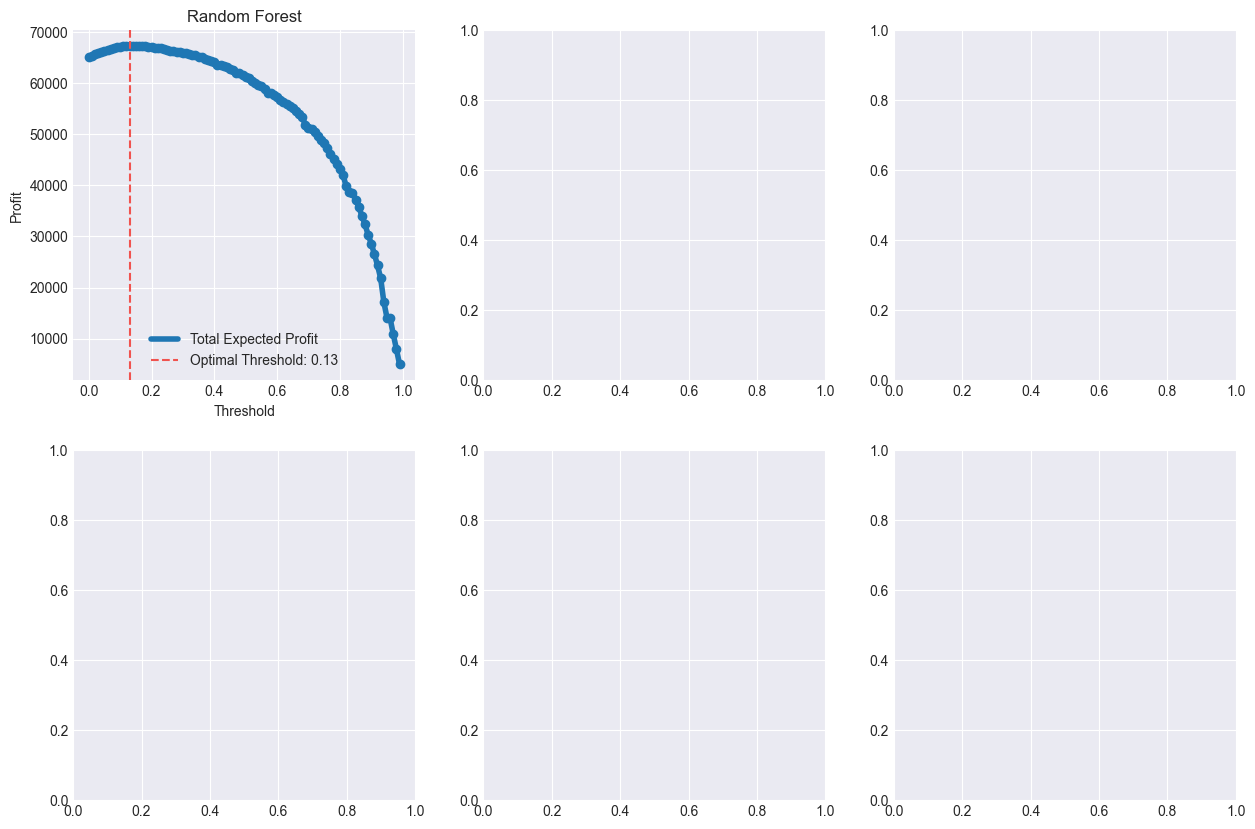

In [20]:
_, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax, (name, metric) in zip(axes.flatten(), metrics.items()):
    (
        thresholds,
        profits,
        optimal_threshold,
        profit,
        profit_margin,
    ) = metric
    plot_profit_thresholds(
        profits,
        thresholds,
        optimal_threshold,
        ax=ax,
        model_name=name,
    )

In [21]:
# Prepare headers and metrics for the table
headers = ["Metric"] + list(metrics.keys())

table = []
# Prepare table: each row is a model, columns are metrics
metric_names = ["Optimal Threshold", "Profit", "Profit Margin"]
table = [
    [
        name,
        f"{metrics[name][2]:.3f}",  # Optimal Threshold
        f"{metrics[name][3]:,}",  # Profit
        f"{metrics[name][4]:.2%}",  # Profit Margin
    ]
    for name in metrics
]
headers = ["Model"] + metric_names


print(tabulate(table, headers, tablefmt="github"))

| Model         |   Optimal Threshold | Profit   | Profit Margin   |
|---------------|---------------------|----------|-----------------|
| Random Forest |                0.13 | 67,240   | 84.45%          |


In [22]:
# Select classifier with highest maximum profit
selected_model_name = max(metrics.items(), key=lambda x: x[1][2])[0]
# Grab the best model based on the name
selected_model = classifiers[selected_model_name][0]

print(f"Selected model: {selected_model_name}")

Selected model: Random Forest


In [23]:
train_sizes, train_scores, test_scores = learning_curve(
    selected_model,
    X_resampled,
    y_resampled,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state),
    n_jobs=-1,
    random_state=random_state,
    scoring=maximum_profit_scorer,
)

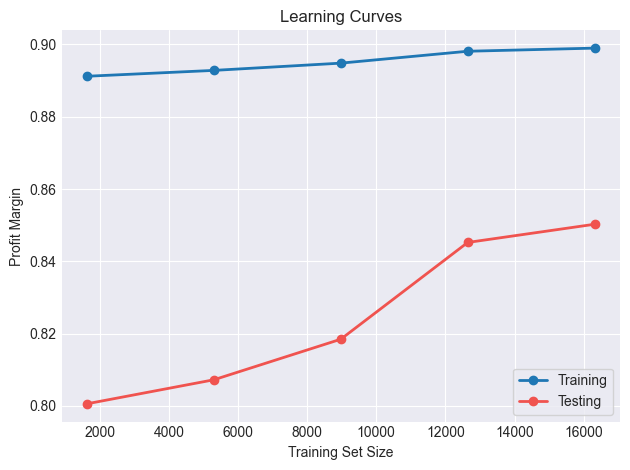

In [24]:
plt.figure()
plt.plot(
    train_sizes,
    train_scores.mean(axis=1),
    color=HONOLULU_BLUE,
    label="Training",
    linewidth=2,
    marker="o",
)
plt.plot(
    train_sizes,
    test_scores.mean(axis=1),
    color=IMPERIAL_RED,
    label="Testing",
    linewidth=2,
    marker="o",
)
plt.xlabel("Training Set Size")
plt.ylabel("Profit Margin")
plt.title("Learning Curves")
plt.legend(frameon=True)
plt.tight_layout()
plt.show()

In [25]:
# Fit the selected model on the balanced training data
selected_model.fit(X_train, y_train)
# Predict probabilities on the test set
y_prob = selected_model.predict_proba(X_test)[:, 1]
y_pred = selected_model.predict(X_test)

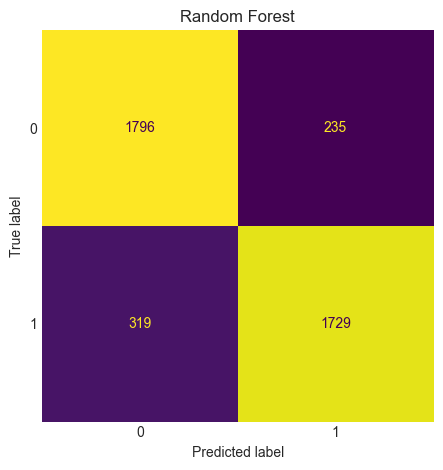

In [26]:
plt.style.use("seaborn-v0_8-dark")

fig, ax = plt.subplots()

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    ax=ax,
    colorbar=False,
)
ax.set_title(selected_model_name)

plt.tight_layout()
plt.show()

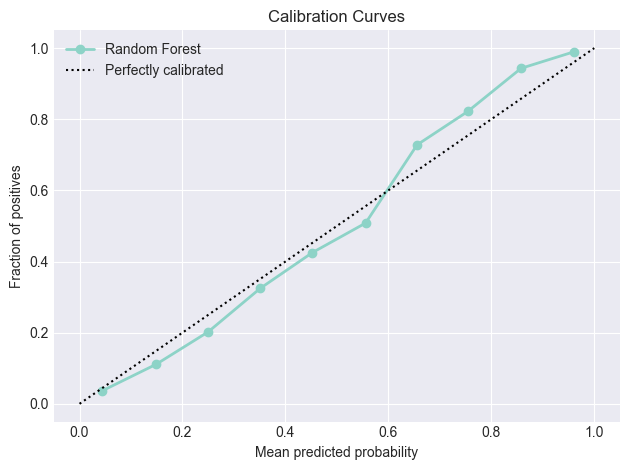

In [27]:
plt.style.use("seaborn-v0_8-darkgrid")

plt.figure()

prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
plt.plot(prob_pred, prob_true, marker="o", label=selected_model_name, linewidth=2)

plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curves")
plt.legend()
plt.tight_layout()
plt.show()

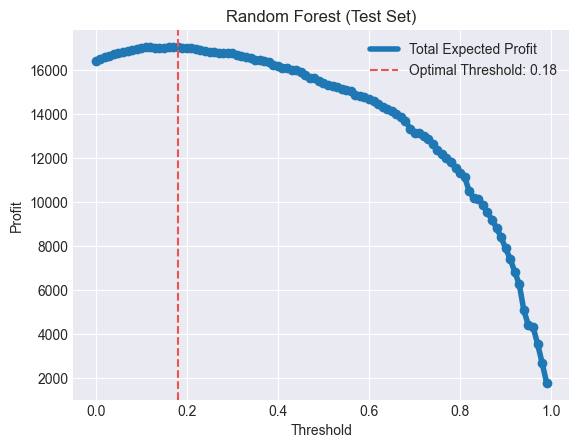

Optimal Threshold 0.180
Profit 17,044
Profit Margin 0.858


In [29]:
(
    thresholds,
    profits,
    optimal_threshold,
    profit,
    profit_margin,
) = calculate_profit_thresholds(y_test, y_prob)

fig, ax = plt.subplots()
plot_profit_thresholds(
    profits,
    thresholds,
    optimal_threshold,
    ax=ax,
    model_name=f"{selected_model_name} (Test Set)",
)
plt.show()

print("Optimal Threshold", f"{optimal_threshold:.3f}")
print("Profit", f"{profit:,}")
print("Profit Margin", f"{profit_margin:.3f}")